In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy import stats

In [2]:
# Function to load FITS data
def load_fits_data(fits_file_path):
    """Loads FITS file data and returns the relevant columns."""
    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data
        return data['x'], data['y'], data['z'], data['A_O']

In [3]:
# Function to calculate galactocentric radius
def calculate_galactocentric_radius(x, y, z):
    """Calculates the galactocentric radius given x, y, z coordinates."""
    return np.sqrt(x**2 + y**2 + z**2)

In [4]:
# Define a linear model for curve fitting
def linear_model(x, a, b):
    """Linear model: y = ax + b."""
    return a * x + b


In [5]:
# Function to fit the linear model and return parameters and residuals
def fit_linear_model(RGal, ao):
    """Fits a linear model to the data and returns parameters, residuals, and uncertainties."""
    params, covariance = curve_fit(linear_model, RGal, ao)
    slope, intercept = params
    slope_err, intercept_err = np.sqrt(np.diag(covariance))
    residuals = ao - linear_model(RGal, slope, intercept)
    return slope, intercept, slope_err, intercept_err, residuals


In [6]:
# Function to plot hexbin and residuals
def plot_hexbin_and_residuals(RGal, ao, slope, intercept, residuals, save_path):
    """Plots a logarithmic density plot and residuals."""
    x_fit = np.linspace(min(RGal), max(RGal), 1000)
    ao_fitted = linear_model(x_fit, slope, intercept)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Logarithmic density plot
    hb = ax[0].hexbin(RGal, ao, gridsize=50, cmap='plasma', bins='log', norm=LogNorm(), mincnt=1)
    fig.colorbar(hb, ax=ax[0], label='Log(Density)', extend='both')
    ax[0].plot(x_fit, ao_fitted, color='white', lw=2, label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
    ax[0].set_xlabel('Galactocentric Radius RGal (kpc)', fontsize=12)
    ax[0].set_ylabel('Gas Phase Metallicity A(O)', fontsize=12)
    ax[0].set_title('Logarithmic Density Plot of RGal vs A(O)', fontsize=14)
    ax[0].legend(facecolor='white', framealpha=1, fontsize=10)

    # Residuals plot
    ax[1].scatter(RGal, residuals, s=15, color='blue', alpha=0.7, edgecolor='black', linewidth=0.5, label='Residuals')
    ax[1].axhline(0, color='red', linestyle='--', lw=1, label='Zero Residual')
    ax[1].set_xlabel('Galactocentric Radius RGal (kpc)', fontsize=12)
    ax[1].set_ylabel('Residuals ∆A(O)', fontsize=12)
    ax[1].set_title('Residuals of Linear Fit (RGal vs ∆A(O))', fontsize=14)
    ax[1].legend(facecolor='white', framealpha=1, fontsize=10)

    for axis in ax:
        axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


In [7]:
# Function to calculate and plot 2D histograms
def plot_2d_histograms(x, y, ao, RGal, slope, intercept, residuals, save_path):
    """Plots 2D histograms of simulated, fitted A(O), and residuals."""
    x_bins = np.linspace(min(x), max(x), 100)
    y_bins = np.linspace(min(y), max(y), 100)
    
    # Binned statistics
    simulated_AO_hist, xedges, yedges, _ = stats.binned_statistic_2d(x, y, ao, statistic='median', bins=[x_bins, y_bins])
    fitted_AO_hist, _, _, _ = stats.binned_statistic_2d(x, y, linear_model(RGal, slope, intercept), statistic='median', bins=[x_bins, y_bins])
    residuals_hist, _, _, _ = stats.binned_statistic_2d(x, y, residuals, statistic='median', bins=[x_bins, y_bins])
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Simulated A(O)
    img1 = ax[0].imshow(simulated_AO_hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                        aspect='equal', origin='lower', cmap='inferno', vmin=np.min(ao), vmax=np.max(ao))
    ax[0].set_title('Simulated A(O)', fontsize=14)
    fig.colorbar(img1, ax=ax[0], label='Median Simulated A(O)')

    # Fitted A(O)
    img2 = ax[1].imshow(fitted_AO_hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                        aspect='equal', origin='lower', cmap='magma', vmin=np.min(ao), vmax=np.max(ao))
    ax[1].set_title('Fitted A(O)', fontsize=14)
    fig.colorbar(img2, ax=ax[1], label='Median Fitted A(O)')

    # Residuals
    img3 = ax[2].imshow(residuals_hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                        aspect='equal', origin='lower', cmap='coolwarm', vmin=-np.max(np.abs(residuals)), vmax=np.max(np.abs(residuals)))
    ax[2].set_title('Residuals ∆A(O)', fontsize=14)
    fig.colorbar(img3, ax=ax[2], label='Median Residuals ∆A(O)')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

/var/folders/hq/jjm583ks6d1gz_c4tzrnclkm0000gn/T/ipykernel_85527/628303280.py:10: UserWarning: Only one of 'bins' and 'norm' arguments can be supplied, ignoring bins=log
  hb = ax[0].hexbin(RGal, ao, gridsize=50, cmap='plasma', bins='log', norm=LogNorm(), mincnt=1)


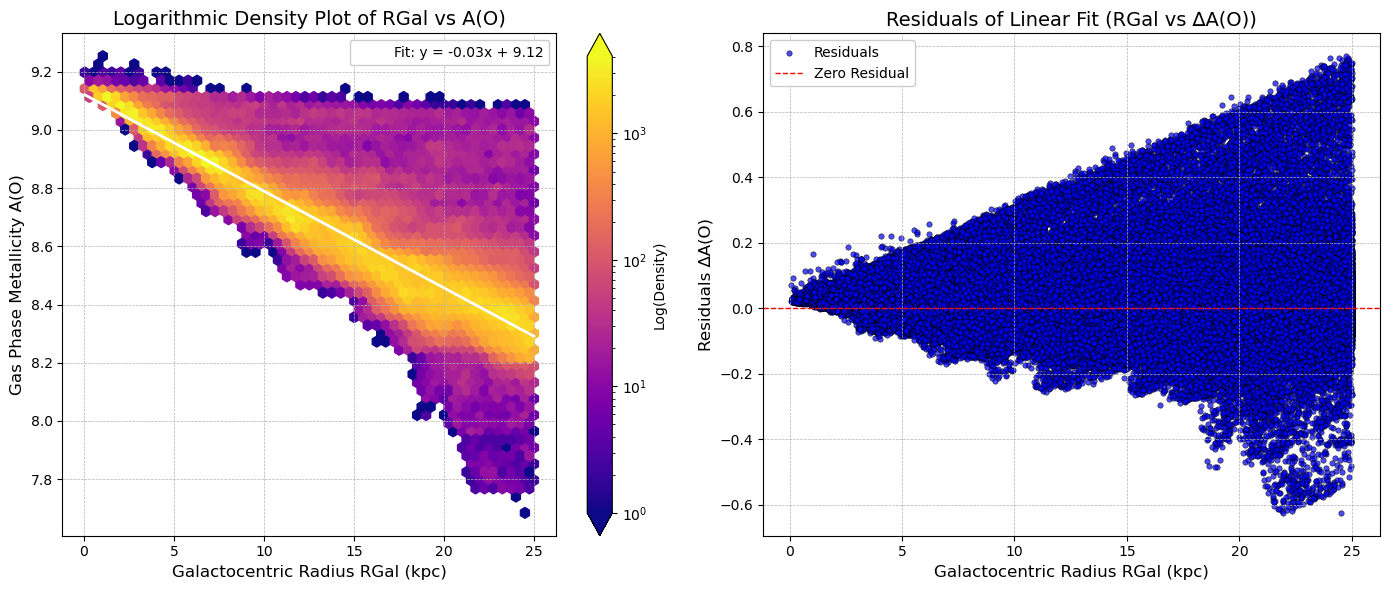

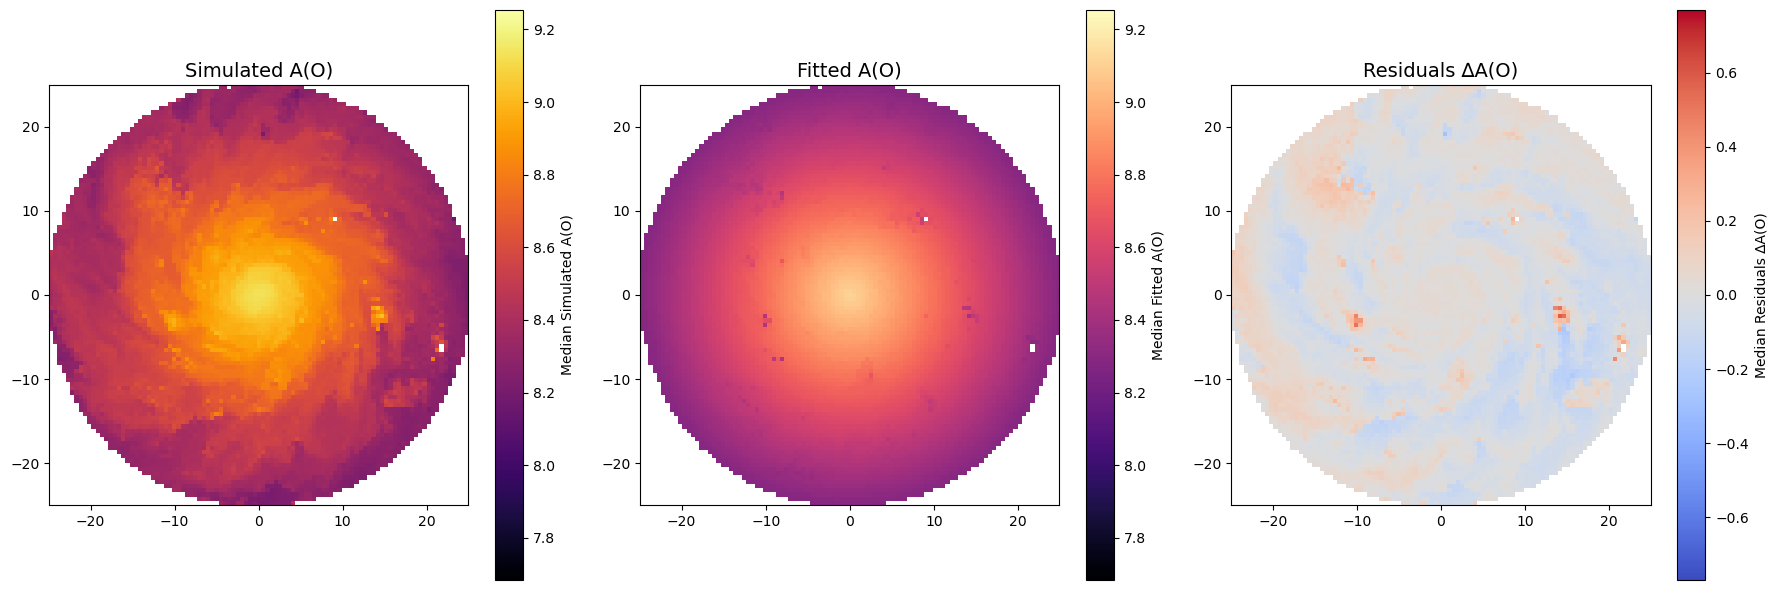

Root Mean Square Error (RMSE): 0.088
R-squared: 0.873
Mean of residuals: 0.000
Maximum absolute residual: 0.770
Slope: -0.033 ± 0.000
Intercept: 9.122 ± 0.000


In [9]:
# Main code execution
fits_file_path = "/Users/shaniatham/ASTR4004/astro_computing/ASTR4004_U7392929/data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits"
x, y, z, ao = load_fits_data(fits_file_path)
RGal = calculate_galactocentric_radius(x, y, z)
slope, intercept, slope_err, intercept_err, residuals = fit_linear_model(RGal, ao)

# Plot the hexbin and residuals
plot_hexbin_and_residuals(RGal, ao, slope, intercept, residuals, '/Users/shaniatham/ASTR4004/astro_computing/ASTR4004_U7392929/figures/hexbin_residuals.png')

# Plot the 2D histograms
plot_2d_histograms(x, y, ao, RGal, slope, intercept, residuals, '/Users/shaniatham/ASTR4004/astro_computing/ASTR4004_U7392929/figures/2D_histograms.png')

# Print results
# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")

# Calculate R-squared (coefficient of determination)
ss_total = np.sum((ao - np.mean(ao))**2)  # Total sum of squares
ss_res = np.sum(residuals**2)  # Residual sum of squares
r_squared = 1 - (ss_res / ss_total)
print(f"R-squared: {r_squared:.3f}")

# Analyze residuals
mean_residuals = np.mean(residuals)
max_residuals = np.max(np.abs(residuals))
print(f"Mean of residuals: {mean_residuals:.3f}")
print(f"Maximum absolute residual: {max_residuals:.3f}")

# Slope and intercept with uncertainties
print(f"Slope: {slope:.3f} ± {slope_err:.3f}")
print(f"Intercept: {intercept:.3f} ± {intercept_err:.3f}")


## Choice of 2D Bins

We selected 100 bins along both the x and y axes to achieve a balance between resolution and readability. This bin size provides sufficient detail to capture spatial variations in gas-phase metallicity \( A(O) \), revealing localized features such as the spiral structure of the galaxy and variations near the galactic center. Fewer bins (e.g., 20-50) would result in less precision, smoothing out critical details like the spiral arms and finer metallicity gradients. This would blur important features, making it harder to detect discrepancies between the model and the data. On the other hand, using more bins (e.g., 200 or more) could overcomplicate the plot, introducing noise that obscures the major trends. With more bins, each bin would contain fewer data points, reducing the statistical significance of the median values and increasing random variation, which could lead to misinterpretation of the data. Therefore, 100 bins offer an optimal compromise to reveal significant patterns while maintaining clarity.


## Analyze the residuals
The residuals in the spiral structure reveal that the linear model struggles to capture the complex variations in metallicity along the spiral arms of the galaxy. These regions are often sites of heightened star formation, where gas dynamics, such as inflows and outflows, lead to uneven distributions of metals. Consequently, the linear model falls short of accurately predicting \( A(O) \) in these areas. By contrast, near the galactic center, the model performs well, as the residuals are minimal. This suggests that the central region has a smoother metallicity gradient, likely due to the well-mixed gas present in these areas. In the outer regions of the galaxy, particularly along the spiral arms, we observe larger residuals, both positive and negative,highlighting the model’s inability to account for localized metallicity variations. Such variations may be driven by radial migration of stars, which can transport metal-rich stars between regions, further complicating the metallicity distribution. Additionally, regions with positive residuals (red) reflect areas of recent star formation, where the model underpredicts metallicity, while negative residuals (blue) indicate areas where the model overpredicts, likely due to inflows of low-metallicity gas or the presence of older stars. The spiral arms and outer regions exhibit complex dynamics that a simple linear model cannot fully capture, thus necessitating more sophisticated modeling techniques to address the non-linear metallicity variations driven by processes such as star formation, gas flows, and stellar migration.
